# 0. Introduction

kaggle/python Docker image: https://github.com/kaggle/docker-python

# 1. Initialization

## 1.1. (most) package imports

In [1]:
import gc
import time
import os
import re
from contextlib import contextmanager
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from IPython.display import clear_output

import math
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 20, "display.max_columns", 30)
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import imblearn.pipeline
#from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import make_scorer

from sklearn.dummy import DummyClassifier
#from sklearn.utils.testing import ignore_warnings # For LogisticRegression
#from sklearn.exceptions import ConvergenceWarning # For LogisticRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import shap

## 1.2. Global variables

In [2]:
offline = True

## 1.3. Global functions

In [3]:
@contextmanager
def timer(title):
    t0 = time.perf_counter()
    yield
    print("{} - done in {:.0f}s".format(title, time.perf_counter() - t0))

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## 1.4. Dataset overview

offline j'ai:

<p style="background:black">
<code style="background:black;color:white">filenames = [
    "home-credit-default-risk/application_test.csv",
    "home-credit-default-risk/application_train.csv",
    "home-credit-default-risk/bureau.csv",
    "home-credit-default-risk/bureau_balance.csv",
    "home-credit-default-risk/credit_card_balance.csv",
    "home-credit-default-risk/installments_payments.csv",
    "home-credit-default-risk/POS_CASH_balance.csv",
    "home-credit-default-risk/previous_application.csv",
    "home-credit-default-risk/sample_submission.csv"
    ]
</code>
</p>

not offline (on Kaggle) j'ai:

<p style="background:black">
<code style="background:black;color:white">filenames = [
    "/kaggle/input/home-credit-default-risk/sample_submission.csv",
    "/kaggle/input/home-credit-default-risk/bureau_balance.csv",
    "/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv",
    "/kaggle/input/home-credit-default-risk/application_train.csv",
    "/kaggle/input/home-credit-default-risk/application_test.csv",
    "/kaggle/input/home-credit-default-risk/previous_application.csv",
    "/kaggle/input/home-credit-default-risk/credit_card_balance.csv",
    "/kaggle/input/home-credit-default-risk/installments_payments.csv",
    "/kaggle/input/home-credit-default-risk/bureau.csv"]
    ]
</code>
</p>

In [4]:
if offline:
    le_path = "home-credit-default-risk/"
else:
    le_path = "/kaggle/input"

In [5]:
filenames = []
for dirname, _, filenamess in os.walk(le_path):
    for filenamee in filenamess:
#                        HomeCredit_columns_description.csv est illisible.
        if filenamee != "HomeCredit_columns_description.csv":
            filename = os.path.join(dirname, filenamee)
#            print(filename)
            filenames.append(filename)
#            df = pd.read_csv(filename)
#            display(df[-1:])

In [6]:
if not offline:
    flnms = []
    flnms.append(filenames[4])
    flnms.append(filenames[3])
    flnms.append(filenames[8])
    flnms.append(filenames[1])
    flnms.append(filenames[6])
    flnms.append(filenames[7])
    flnms.append(filenames[2])
    flnms.append(filenames[5])
    flnms.append(filenames[0])
    filenames = flnms

# 2. Preprocessing

## 2.1. application_train and application_test

In [7]:
def application_train_test(num_rows=None, nan_as_category=False):
    df = pd.read_csv(filenames[1], nrows=num_rows)
    test_df = pd.read_csv(filenames[0], nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()

    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df["CODE_GENDER"] != "XNA"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Aberrant values
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]

    del test_df
    gc.collect()
    return df

## 2.2. bureau and bureau_balance

In [8]:
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv(filenames[2], nrows=num_rows)
    bb = pd.read_csv(filenames[3], nrows=num_rows)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {"MONTHS_BALANCE": ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]
    )
    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "AMT_CREDIT_MAX_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
        "AMT_ANNUITY": ["max", "mean"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "MONTHS_BALANCE_MIN": ["min"],
        "MONTHS_BALANCE_MAX": ["max"],
        "MONTHS_BALANCE_SIZE": ["mean", "sum"]
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ["mean"]
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ["mean"]

    bureau_agg = bureau.groupby("SK_ID_CURR").agg(
        {**num_aggregations, **cat_aggregations}
    )
    bureau_agg.columns = pd.Index([
        "BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()
    ])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index([
        "ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index([
        "CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")
    del closed, closed_agg, bureau
    gc.collect()

    return bureau_agg

## 2.3. previous_applications

In [9]:
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv(filenames[7], nrows=num_rows)

    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Aberrant values
    prev["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace=True)
    prev["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_TERMINATION"].replace(365243, np.nan, inplace=True)

    # Add feature: value ask / value received percentage
    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]

    # Previous applications numeric features
    num_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "APP_CREDIT_PERC": ["min", "max", "mean", "var"],
        "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT": ["min", "max", "mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ["mean"]

    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations,
                                               **cat_aggregations})
    prev_agg.columns = pd.Index([
        "PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()
    ])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index([
        "APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index([
        "REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")

    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

## 2.4. pos_cash

In [10]:
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv(filenames[6], nrows=num_rows)

    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # Features
    aggregations = {
        "MONTHS_BALANCE": ["max", "mean", "size"],
        "SK_DPD": ["max", "mean"],
        "SK_DPD_DEF": ["max", "mean"]
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index([
        "POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()
    ])

    # Count pos cash accounts
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()

    del pos
    gc.collect()
    return pos_agg

## 2.5. installment_payments

In [11]:
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv(filenames[5], nrows=num_rows)

    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # Features
    # Percentage and difference paid in each installment (amount paid and
    # installment value)
    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]
    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "PAYMENT_PERC": ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"]
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index([
        "INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()
    ])

    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()

    del ins
    gc.collect()
    return ins_agg

## 2.6. credit_card_balance

In [12]:
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv(filenames[4], nrows=num_rows)

    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # General aggregations
    cc.drop(["SK_ID_PREV"], axis=1, inplace =True)

    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index([
        "CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()
    ])

    # Count credit card lines
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()

    del cc
    gc.collect()
    return cc_agg

# 3. functions from the original notebook

In [13]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df["TARGET"].notnull()]
    test_df = df[df["TARGET"].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(
        train_df.shape, test_df.shape
    ))
    del df
    gc.collect()

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds,
                                shuffle=True,
                                random_state=1001)
    else:
        folds = KFold(n_splits=num_folds,
                      shuffle=True,
                      random_state=1001)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ["TARGET",
                                                      "SK_ID_CURR",
                                                      "SK_ID_BUREAU",
                                                      "SK_ID_PREV",
                                                      "index"]]

    for n_fold, (train_idx, valid_idx) in enumerate(
            folds.split(train_df[feats], train_df["TARGET"])
    ):
        train_x, train_y = train_df[feats].iloc[train_idx],\
                           train_df["TARGET"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx],\
                           train_df["TARGET"].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
        )

        clf.fit(train_x,
                train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric="auc",
                verbose=200,
                early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(
            valid_x,
            num_iteration=clf.best_iteration_
        )[:, 1]
        sub_preds += clf.predict_proba(
            test_df[feats],
            num_iteration=clf.best_iteration_
        )[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df],
            axis=0
        )
        print("Fold %2d AUC : %.6f" % (
            n_fold + 1,
            roc_auc_score(valid_y, oof_preds[valid_idx])
        ))

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Write submission file and plot feature importance
    print("Full AUC score %.6f" % roc_auc_score(train_df["TARGET"], oof_preds))
    if not debug:
        test_df["TARGET"] = sub_preds
        test_df[["SK_ID_CURR", "TARGET"]].to_csv(submission_file_name,
                                                 index=False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [14]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby(
        "feature"
    ).mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)
    ]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance",
                y="feature",
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()

    plt.savefig("lgbm_importances01.png")

# 4. Run the preprocessing

In [15]:
def preproc(debug=True):
    num_rows = debug if debug else None
    with timer("Process application train test"):
        df = application_train_test(num_rows)
        print("Application train test df shape:", df.shape)
        # print(df.dtypes.value_counts())
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del cc
        gc.collect()

    zeros = df.TARGET.value_counts(
        sort=True,
        ascending=False,
        dropna=True,
    )[0]
    ones = df.TARGET.value_counts(
        sort=True,
        ascending=False,
        dropna=True,
    )[1]
    nans = df.TARGET.isna().sum()
    print("-----------------------------------------------------------------------")
    if debug:
        print("subsampled df's TARGET has",
              f"{zeros:10.0f} zeros,",
              f"{ones:10.0f} ones and",
              f"{nans:10.0f} NaNs")
    else:
        print("TARGET has",
              f"{zeros:10.0f} zeros,",
              f"{ones:10.0f} ones and",
              f"{nans:10.0f} NaNs")

    return zeros, ones, nans, df

## 4.1. A first full run just to measure the target imbalance

In [16]:
%%script echo
# I ran this cell only once, just to get the exact values of zo and oz.
if __name__ == "__main__":
    with timer("preproc_full"):
        zeros_full, ones_full, nans_full, df_full = preproc(debug=False)

Couldn't find program: 'echo'


In [17]:
zeros_full, ones_full, nans_full = 282682, 24825, 48744

In [18]:
zo = zeros_full/ones_full
oz = ones_full/zeros_full
print("There is zo =",
      f"{zo:.2f} more zeros than ones in TARGET. (and oz =",
      f"{oz:.2f})")

There is zo = 11.39 more zeros than ones in TARGET. (and oz = 0.09)


## 4.2. Subsampled run

### 4.2.1. Run the preprocessing

In [19]:
if __name__ == "__main__":
    with timer("preproc_subsampled"):
        # I tried 1_000 here but the ROC AUC scores obtained were > 90% which
        # proves overfitting.
        zeros, ones, nans, df = preproc(debug=100_000)

Train samples: 100000, test samples: 48744
Application train test df shape: (148741, 248)
Process application train test - done in 1s
Bureau df shape: (23121, 113)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (79977, 247)
Process previous_applications - done in 1s
Pos-cash balance df shape: (77469, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (48591, 26)
Process installments payments - done in 0s
Credit card balance df shape: (53383, 131)
Process credit card balance - done in 1s
-----------------------------------------------------------------------
subsampled df's TARGET has      91904 zeros,       8093 ones and      48744 NaNs
preproc_subsampled - done in 5s


### 4.2.3. Measure of the target imbalance after the subsampling is done.

In [20]:
zo_sub = zeros/ones
oz_sub = ones/zeros
print("There is zo_sub =",
      f"{zo_sub:.2f} more zeros than ones in TARGET. (and oz_sub =",
      f"{oz_sub:.2f})")

There is zo_sub = 11.36 more zeros than ones in TARGET. (and oz_sub = 0.09)


In [21]:
if (zo/zo_sub >= 3/2 or zo/zo_sub <= 2/3):
    for _ in range(8):
        print("!")
    print(
        "L'imbalance des targets a été fortement modifiée par le subsampling.",
        f"Elle est passée de {zo:.2f} à {zo_sub:.2f}.",
    )
    for _ in range(8):
        print("!")
else:
    print(
        f"L'imbalance de {zo:.2f} des targets du dataset est de {zo_sub:.2f}",
        "après subsampling.",
    )

L'imbalance de 11.39 des targets du dataset est de 11.36 après subsampling.


# 6. Suppression du caractère illisible

In [22]:
cols_of_df = list(df.columns)

In [23]:
%%script echo skipped
# Ce code prend un temps infini à run. Prende la cell en-dessous.
for j in cols_of_df:
    df = df.rename(columns={j: re.sub(r"[ ]", r"_a_", j)})
    df = df.rename(columns={j: re.sub(r"[-]", r"_b_", j)})
    df = df.rename(columns={j: re.sub(r"[:]", r"_c_", j)})
    df = df.rename(columns={j: re.sub(r"[/]", r"_d_", j)})
    df = df.rename(columns={j: re.sub(r"[,]", r"_e_", j)})
    df = df.rename(columns={j: re.sub(r"[:]", r"_f_", j)})

Couldn't find program: 'echo'


In [24]:
#%%script echo skipped
df = df.rename(columns=lambda x: x.replace(" ", "_a_")\
                                  .replace("-", "_b_")\
                                  .replace(":", "_c_")\
                                  .replace("/", "_d_")\
                                  .replace(",", "_e_")\
                                  .replace(":", "_f_"))

In [25]:
#df = df.rename(columns=lambda x: x.replace(":", "deuxpoints"))

# 7. Classification run from the original notebook

In [26]:
%%script echo skipped
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds=10, stratified=False, debug=False)

Couldn't find program: 'echo'


# 8. Classifications

## 8.0. Suppression des données sans TARGET et colonnes sans données
En effet mon but ici c'est juste de créer un modèle qui fonctionne, faire les
 prédictions de solvabilité des futurs clients ça sera pour plus tard.

In [27]:
df = df[df["TARGET"].notnull()]

In [28]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [29]:
cols_notnull = list(df.loc[:, df.notnull().sum() > 0].columns)

In [30]:
np.isinf(df).sum()[np.isinf(df).sum() > 0]

Series([], dtype: int64)

In [31]:
df = df.loc[:, cols_notnull]

## 8.1. train_test_split

In [32]:
X = df.drop("TARGET", axis="columns")
y = df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [33]:
y_train.value_counts()

0.0    73518
1.0     6479
Name: TARGET, dtype: int64

## 8.2. SimpleImputer

In [34]:
#pip install --upgrade scikit-learn

In [35]:
sklearn.__version__

'1.2.0'

In [36]:
#X_train_old = X_train.copy()

In [37]:
feature_names_old = list(X_train.columns)
imputer = SimpleImputer(strategy="mean")
#X_train_i = imputer.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)
feature_names = imputer.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)

In [38]:
X_test_old = X_test.copy()
# X_test = imputer.fit_transform(X_test_old)
X_test = imputer.transform(X_test_old) # pas de fit, recommandé par mentor
X_test = pd.DataFrame(X_test, columns=feature_names)

In [39]:
X_test.shape

(20000, 779)

## 8.3. Balancing the target

In [40]:
undersampler = RandomUnderSampler(sampling_strategy="majority")
#X_train_u, y_train_u = undersampler.fit_resample(X_train_i, y_train)

In [41]:
oversampler_1 = RandomOverSampler(sampling_strategy="not majority")
# La doc de imblearn dit exactement l'inverse mais ici j'ai cette erreur:
#
# ValueError: The 'sampling_strategy' parameter of RandomOverSampler must be a
# float in the range (0, 1], a str among {'majority', 'not majority', 'all',
# 'auto', 'not minority'}, an instance of 'collections.abc.Mapping' or a
# callable. Got 'minority' instead.
oversampler_2 = SMOTE()
#X_train_o, y_train_o = oversampler.fit_resample(X_train_i, y_train)

## 8.4. Declaring the classifiers

In [42]:
clf0 = DummyClassifier()
clf1 = LogisticRegression(random_state=42, n_jobs=1, solver="sag")
clf2 = SGDClassifier()
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = KNeighborsClassifier()
clf6 = SVC(probability=True, random_state=42)
clf7 = DecisionTreeClassifier(random_state=42)
clf8 = RandomForestClassifier(random_state=42)
clf9 = GradientBoostingClassifier(random_state=42)
clf10 = AdaBoostClassifier(random_state=42)
clf11 = XGBClassifier(random_state=42)
# Even with logging_level="info" catboost prints millions of lines and crashes
# my computer so i need logging_level="Silent" here.
clf12 = CatBoostClassifier(random_state=42, logging_level="Silent")
clf13 = LGBMClassifier(random_state=42, verbose=-1)

## 8.5. Declaring the classifiers' parameters

### 8.5.0. DummyClassifier

In [43]:
param0 = {}
param0["classifier__strategy"] = ["most_frequent",
                                  "prior"]
param0["classifier"] = [clf0]
#param0["classifier"] = [classifiers[0]]

### 8.5.1. LogisticRegression

In [44]:
param1 = {}
param1["classifier__C"] = [
    10**-2,
    10**-1,
    10**0,
    10**1,
    # 10**2,
]
param1["classifier__penalty"] = [
    # The default solver lbfgs supports only l2 penalty and None.
    # "l1",
    "l2",
    # "elasticnet",
]
# param1["classifier__class_weight"] = [{0: 1, 1: 1},
#                                       {0: oz, 1: zo}]
# param1["classifier__class_weight"] = [None]
# param1["classifier__class_weight"] = [None,
#                                       {0: oz, 1: zo}]
# Je rajoute les class_weights et leurs variantes plus tard dans un if.
param1["classifier"] = [clf1]
#param1["classifier"] = [classifiers[1]]

### 8.5.2. SGDClassifier

In [45]:
param2 = {}
param2["classifier__loss"] = [
    "hinge",
    "log",
    "squared_hinge",
    "modified_huber",
]
param2["classifier__penalty"] = [
    # "l1",
    # "l2",
    "elasticnet",
]
param2["classifier"] = [clf2]
#param2["classifier"] = [classifiers[2]]

### 8.5.3. GaussianNB

In [46]:
param3 = {}
param3["classifier"] = [clf3]
#param3["classifier"] = [classifiers[3]]

### 8.5.4. MultinomialNB

In [47]:
param4 = {}
param4["classifier__alpha"] = [
    10**0,
    10**1,
    # 10**2,
]
param4["classifier"] = [clf4]
#param4["classifier"] = [classifiers[4]]

### 8.5.5. KNeighborsClassifier

In [48]:
param5 = {}
param5["classifier__n_neighbors"] = [
    int(10**.5),
    10**1,
    10**2,
    10**3,
]
param5["classifier__weights"] = [
    "uniform",
    "distance",
]
param5["classifier"] = [clf5]
#param5["classifier"] = [classifiers[5]]

### 8.5.6. SVC

In [49]:
param6 = {}
param6["classifier__kernel"] = ["linear",
                                "rbf",
                                "poly",
                                "sigmoid"]
param6["classifier__C"] = [10**-2,
                           10**-1,
                           10**0,
                           10**1,
                           10**2,
                           10**3]
param6["classifier__gamma"] = ["auto",
                               "scale"]
param6["classifier"] = [clf6]
#param6["classifier"] = [classifiers[6]]

### 8.5.7. DecisionTreeClassifier

In [50]:
param7 = {}
param7["classifier__max_depth"] = [
    int(10**.5),
    10**1,
    # int(10**1.5),
    None,
]
param7["classifier__min_samples_split"] = [
    int(10**.5),
    10**1,
]
param7["classifier__criterion"] = [
    "gini",
    "entropy",
]
param7["classifier"] = [clf7]
#param7["classifier"] = [classifiers[7]]

### 8.5.8. RandomForestClassifier

In [51]:
param8 = {}
param8["classifier__n_estimators"] = [
    int(10**1.5),
    10**2,
]
param8["classifier__max_depth"] = [
    int(10**.5),
    10**1,
    # int(10**1.5),
    None,
]
param8["classifier__criterion"] = [
    "gini",
    "entropy",
]
param8["classifier"] = [clf8]
#param8["classifier"] = [classifiers[8]]

### 8.5.9. GradientBoostingClassifier

In [52]:
param9 = {}
param9["classifier__n_estimators"] = [10**1,
                                      10**2,
                                      10**3]
param9["classifier__max_depth"] = [3,
                                   10**1,
                                   30]
param9["classifier"] = [clf9]
#param9["classifier"] = [classifiers[9]]

### 8.5.10. AdaBoostClassifier

In [53]:
param10 = {}
param10["classifier__n_estimators"] = [10**1,
                                       10**2,
                                       10**3]
param10["classifier__learning_rate"] = [10**-3,
                                        10**-2,
                                        10**-1]
param10["classifier"] = [clf10]
#param10["classifier"] = [classifiers[10]]

### 8.5.11. XGBClassifier

In [54]:
param11 = {}
param11["classifier__booster"] = [
    # "gbtree",
    # gblinear doesn't support max_depth
    # "gblinear",
    "dart",
]
param11["classifier__learning_rate"] = [
    # 10**-3,
    # 10**-2,
    10**-.5,
    10**-1,
]
param11["classifier__max_depth"] = [
    6,
    10**1,
]
param11["classifier"] = [clf11]
#param11["classifier"] = [classifiers[11]]

### 8.5.12. CatBoostClassifier

In [55]:
param12 = {}
param12["classifier__iterations"] = [
    # 10**1,
    # 10**2,
    10**3,
]
param12["classifier__learning_rate"] = [
    # 10**-3,
    10**-2,
    10**-1,
]
param12["classifier__depth"] = [
    # 10**0,
    # 3,
    6,
    10**1,
]
param12["classifier"] = [clf12]
#param12["classifier"] = [classifiers[12]]

### 8.5.13. LGBMClassifier

In [56]:
param13 = {}
param13["classifier__boosting_type"] = [
    # "gbdt",
    "dart",
    # "goss",
]
param13["classifier__learning_rate"] = [
    # 10**-3,
    10**-2,
    10**-1.5,
    10**-1,
]
param13["classifier__num_leaves"] = [
    10**1,
    int(10**1.5),
    10**2,
]
param13["classifier"] = [clf13]
#param13["classifier"] = [classifiers[13]]

### 8.5bis. Listing des paramètres

In [57]:
nz = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
]

In [58]:
clf = [
    "Dummy",
    "Logistic",
    "SGDC",
    "GaussNB",
    "MultinNB",
    "KNeighbor",
    "SVC",
    "DecisionT",
    "RandomF",
    "GB",
    "AdaB",
    "XGB",
    "CatB",
    "LGBM",
]

In [59]:
clfs = [
    clf0,
    # LogisticReg has trouble converging and is quite slow.
    clf1,
    clf2,
    clf3,
    clf4,
    clf5,
    # No SVC because it never finishes computing.
    clf6,
    clf7,
    clf8,
    clf9,
    # AdaBoost et GBoost sont de loin les plus lents et ne sont pas les
    # meilleurs (ils sont proches des scores des meilleurs néanmoins).
    # Je les abandonne car je ne peux pas attendre de nouveau 10h à chaque fois
    # que je veux faire un nouveau RandomSearchCV.
    clf10,
    clf11,
    clf12,
    clf13,
]

In [60]:
params_full = [
    param0,
    param1,
    param2,
    param3,
    param4,
    param5,
    param6,
    param7,
    param8,
    param9,
    param10,
    param11,
    param12,
    param13,
]

In [61]:
dA = pd.DataFrame(columns=["nz", "clf", "clfs", "params"])

In [62]:
dA.nz = nz
dA.clf = clf
dA.clfs = clfs
dA.params = params_full

In [63]:
# Pour les raisons citées précédemment:
dA.drop(index=[6, 9, 10], inplace=True)

In [64]:
dA

,nz,clf,clfs,params
0,0,Dummy,DummyClassifier(),"{'classifier__strategy': ['most_frequent', 'pr..."
1,1,Logistic,"LogisticRegression(n_jobs=1, random_state=42, ...","{'classifier__C': [0.01, 0.1, 1, 10], 'classif..."
2,2,SGDC,SGDClassifier(),"{'classifier__loss': ['hinge', 'log', 'squared..."
3,3,GaussNB,GaussianNB(),{'classifier': [GaussianNB()]}
4,4,MultinNB,MultinomialNB(),"{'classifier__alpha': [1, 10], 'classifier': [..."
5,5,KNeighbor,KNeighborsClassifier(),"{'classifier__n_neighbors': [3, 10, 100, 1000]..."
7,7,DecisionT,DecisionTreeClassifier(random_state=42),"{'classifier__max_depth': [3, 10, None], 'clas..."
8,8,RandomF,RandomForestClassifier(random_state=42),"{'classifier__n_estimators': [31, 100], 'class..."
11,11,XGB,"XGBClassifier(base_score=None, booster=None, c...","{'classifier__booster': ['dart'], 'classifier_..."
12,12,CatB,<catboost.core.CatBoostClassifier object at 0x...,"{'classifier__iterations': [1000], 'classifier..."


In [65]:
nl = []
for j, k in enumerate(dA.params):
    nl.append(math.prod([len(i) for i in k.values()]))
    print("{:<4}".format(j),
          "{:<32}".format(str(k["classifier"]).split('(')[0][1:]),
          "{:<10.0f}".format(nl[j]))

0    DummyClassifier                  2         
1    LogisticRegression               4         
2    SGDClassifier                    4         
3    GaussianNB                       1         
4    MultinomialNB                    2         
5    KNeighborsClassifier             8         
6    DecisionTreeClassifier           12        
7    RandomForestClassifier           12        
8    XGBClassifier                    4         
9    <catboost.core.CatBoostClassifier object at 0x0000018EBD209D60>] 4         
10   LGBMClassifier                   9         


### 8.5ter. Déclaration des samplers

In [66]:
param_sampler = {}
param_sampler["sampler"] = [
    None,
    # undersampler,
    # oversampler_1,
    oversampler_2
]

## 8.6. Itération sur les classifiers avec une boucle.
Je vais gridsearch les paramètres de chacun des estimateurs et enregistrer le
best_estimator_ obtenu à chaque fois pour pouvoir comparer les estimateurs.

Le problème c'est qu'ici apparemment on veut l'inverse. On veut plutôt random
entre tous les estimateurs pour trouver lequel est le meilleur et ne sortir que
ses stats à lui. Puis recommencer avec une autre technique de sampling.

In [67]:
%%script echo
# C'était juste pour constater qu'il y a pas mal de valeurs négatives
# donc on ne peut pas utiliser MultinomialNB dans l'état
# donc je vais rajouter un MinMaxScaler qui met tout entre 0 et 1.
for co in df.columns:
    neg = (df[co] < 0).sum()
    if neg:
        print("{:<40}".format(co), "{:>5.0f}".format(neg))

Couldn't find program: 'echo'


In [68]:
%%script echo
for sampler in param_sampler["sampler"][0:]:
    for (n, clf, param) in list(zip(nz, clfs, params_full))[0:]:
            n_loops = math.prod([len(i) for i in param.values()])
            print(clf, n_loops)

Couldn't find program: 'echo'


<p style="background:black">
<code style="background:black;color:white">DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
</code>
</p>

In [69]:
def clean_csv(d):
    return d.loc[:, ~d.columns.str.match('Unnamed')]

In [70]:
#scaler = MinMaxScaler(input_features=feature_names)
scaler = MinMaxScaler()
cws = [
    None,
    # {0: .8*oz, 1: zo/.8},
    {0: oz, 1: zo},
    # {0: oz/.8, 1: .8*zo},
]
cws1 = [
    1,
    oz,
    zo,
]

In [71]:
oz, zo

(0.08781952865764357, 11.386988922457201)

In [72]:
%%script echo
result_dfs = dict()
for sampler in param_sampler["sampler"][0:]:
    # I create a different results table for each sampler.
    # str(sampler) includes parentheses and the arguments inside, so i strip
    # these out in order to keep only the name of the sampler.
    nom_du_df = "result_df_" + str(sampler).split('(')[0] + ".csv"
    result_df = pd.DataFrame(columns=[
        "classifier",
        "best_score",
        "avg_score_folds",
        "fold0_score",
        "fold1_score",
        "fold2_score",
        "fold3_score",
        "fold4_score",
        "run_time (s)",
    ])
    # I gridsearch each classifier with its own set of parameters.
    for (n, clf, param) in list(zip(dA.nz, dA.clfs, dA.params))[0:]:
        with timer(str(n)):
            try:
                result_df = pd.read_csv(nom_du_df)
                result_df = clean_csv(result_df)
            except ValueError:
                print("An error occurred while reading the CSV file.")
            except FileNotFoundError:
                print("The file could not be found.")

            t_clf = time.perf_counter()

            # Without sampler i still try to optimize the gridsearch using class_weight.
            if sampler is None:
                # class_weight does not exist for dummy, NBayes, KN, GB, AdaB, XGB.
                # CatBoost either.
                if n in [1, 2, 6, 7, 8, 13]:
                    param["classifier__class_weight"] = cws
                elif n in [12]:
                    param["classifier__class_weights"] = cws
                elif n in [11]:
                    param["classifier__scale_pos_weight"] = cws1

            # Train the model
            # I need a MinMaxScaler in the pipe because (at least) MultinomialNB
            # errors on negative values.
            pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                                   ("sampler", sampler),
                                                   ("classifier", clf)])
            gs = GridSearchCV(
                pipeline,
                param,
                cv=5,
                n_jobs=None,
                scoring="roc_auc",
                # scoring=["roc_auc", "accuracy"],
                # refit="roc_auc",
                # n_iter=5, # seulement pour RandomSearchCV ?
                # random_state=42, # seulement pour RandomSearchCV ?
            ).fit(X_train, y_train)

            n_loops = math.prod([len(i) for i in param.values()])
            t_mean = (time.perf_counter() - t_clf)/(n_loops)
            if t_mean > 10:
                t_mean = round(t_mean, 0)
            elif t_mean > 1:
                t_mean = round(t_mean, 2)
            elif t_mean > .001:
                t_mean = round(t_mean, 3)
            else:
                pass

            # Save the results
            print("Score:", gs.best_score_)
            print("Obtained with:", gs.best_params_["classifier"])
            result_df.loc[n, :] = [
                gs.best_params_["classifier"],
                round(gs.best_score_, 3),
                round(np.mean([
                    gs.cv_results_["split0_test_score"].max(),
                    gs.cv_results_["split1_test_score"].max(),
                    gs.cv_results_["split2_test_score"].max(),
                    gs.cv_results_["split3_test_score"].max(),
                    gs.cv_results_["split4_test_score"].max(),
                ]), 3),
                round(gs.cv_results_["split0_test_score"].max(), 3),
                round(gs.cv_results_["split1_test_score"].max(), 3),
                round(gs.cv_results_["split2_test_score"].max(), 3),
                round(gs.cv_results_["split3_test_score"].max(), 3),
                round(gs.cv_results_["split4_test_score"].max(), 3),
                t_mean
            ]

            # Je save à chaque classifier pour pouvoir relancer la loop à partir
            # du classifier qui bug en cas d'erreur.
            #result_df.sort_index(by="best_score", inplace=True)
            result_df.sort_values(by="best_score", inplace=True)
            result_df.to_csv(nom_du_df)

    result_dfs[str(sampler)] = result_df
    #display(result_df[-2:])

Couldn't find program: 'echo'


<p style="background:black">
<code style="background:black;color:white">The file could not be found.
Score: 0.5
Obtained with: DummyClassifier(strategy='most_frequent')
0 - done in 1s
Score: 0.7250222708935026
Obtained with: LogisticRegression(C=0.1, n_jobs=1, random_state=42, solver='sag')
1 - done in 97s
Score: 0.7099938152168361
Obtained with: SGDClassifier(loss='log', penalty='elasticnet')
2 - done in 60s
Score: 0.4930100602023389
Obtained with: GaussianNB()
3 - done in 1s
Score: 0.6243430795680865
Obtained with: MultinomialNB(alpha=1)
4 - done in 1s
Score: 0.6522858164197481
Obtained with: KNeighborsClassifier(n_neighbors=1000, weights='distance')
5 - done in 10s
Score: 0.6871594822939304
Obtained with: DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=3,
                       random_state=42)
7 - done in 47s
Score: 0.7107564160032682
Obtained with: RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)
8 - done in 97s
Score: 0.7420321268277735
Obtained with: XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
11 - done in 934s
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.
One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.71175619 0.67402221
 0.71084153 0.69628743]
Score: 0.7117561947128614
Obtained with: catboost.core.CatBoostClassifier object at 0x00000175D93E9DC0
12 - done in 1463s
Score: 0.745211332338472
Obtained with: LGBMClassifier(boosting_type='dart', num_leaves=10, random_state=42)
13 - done in 71s
The file could not be found.
Score: 0.5
Obtained with: DummyClassifier(strategy='most_frequent')
0 - done in 2s
Score: 0.713460698256345
Obtained with: LogisticRegression(C=0.01, n_jobs=1, random_state=42, solver='sag')
1 - done in 157s
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Score: 0.6917674294565902
Obtained with: SGDClassifier(class_weight={0: 0.08781952865764357, 1: 11.386988922457201},
              loss='log', penalty='elasticnet')
2 - done in 189s
Score: 0.4993332917231714
Obtained with: GaussianNB()
3 - done in 2s
Score: 0.6189208971907467
Obtained with: MultinomialNB(alpha=10)
4 - done in 2s
Score: 0.6488529780582051
Obtained with: KNeighborsClassifier(n_neighbors=1000, weights='distance')
5 - done in 19s
Score: 0.6381124495713207
Obtained with: DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
7 - done in 226s
Score: 0.6855991012205017
Obtained with: RandomForestClassifier(random_state=42)
8 - done in 348s
Score: 0.7173236343828551
Obtained with: XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
11 - done in 1717s
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.
One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.66966222 0.66499016
 0.66001963 0.66197607]
Score: 0.6696622200534501
Obtained with: catboost.core.CatBoostClassifier object at 0x00000175D93E9DC0
12 - done in 4823s
Score: 0.7069649737004864
Obtained with: LGBMClassifier(boosting_type='dart', random_state=42)
13 - done in 194s
</code>
</p>

In [73]:
#gs.cv_results_

<p style="background:black">
<code style="background:black;color:white">{'mean_fit_time': array([1.12846975, 1.93213859, 3.49252276, 1.20664921, 1.90970011,
        3.44738073, 1.19674945, 1.9298975 , 3.48896518, 1.01345282,
        1.63482342, 3.1525496 , 1.09063888, 1.71527624, 3.28194938,
        1.06873031, 1.62983508, 3.28338637]),
 'std_fit_time': array([0.16328593, 0.02055966, 0.06306082, 0.01070929, 0.07148658,
        0.11888143, 0.05199477, 0.06873583, 0.08543938, 0.02194296,
        0.03327168, 0.13876321, 0.05604037, 0.03026382, 0.19121445,
        0.05841236, 0.01412593, 0.19140034]),
 'mean_score_time': array([0.0305635 , 0.0313375 , 0.0289206 , 0.02932396, 0.03036981,
        0.03311548, 0.03042021, 0.03111563, 0.03199601, 0.02480702,
        0.03254519, 0.03337388, 0.02807384, 0.02978086, 0.03095374,
        0.02895303, 0.03263464, 0.03402157]),
 'std_score_time': array([0.00258001, 0.00388554, 0.00182127, 0.0054116 , 0.00370879,
        0.00366714, 0.00742412, 0.00523109, 0.0009727 , 0.00519239,
        0.00427954, 0.00293639, 0.00158762, 0.00664471, 0.00373306,
        0.00939595, 0.00483121, 0.00494056]),
 'param_classifier': masked_array(data=[LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42),
                    LGBMClassifier(boosting_type='dart', random_state=42)],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__boosting_type': masked_array(data=['dart', 'dart', 'dart', 'dart', 'dart', 'dart', 'dart',
                    'dart', 'dart', 'dart', 'dart', 'dart', 'dart', 'dart',
                    'dart', 'dart', 'dart', 'dart'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__class_weight': masked_array(data=[None, None, None, None, None, None, None, None, None,
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201},
                    {0: 0.08781952865764357, 1: 11.386988922457201}],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.03162277660168379,
                    0.03162277660168379, 0.03162277660168379, 0.1, 0.1,
                    0.1, 0.01, 0.01, 0.01, 0.03162277660168379,
                    0.03162277660168379, 0.03162277660168379, 0.1, 0.1,
                    0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__num_leaves': masked_array(data=[10, 31, 100, 10, 31, 100, 10, 31, 100, 10, 31, 100, 10,
                    31, 100, 10, 31, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.01,
   'classifier__num_leaves': 10},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.01,
   'classifier__num_leaves': 31},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.01,
   'classifier__num_leaves': 100},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.03162277660168379,
   'classifier__num_leaves': 10},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.03162277660168379,
   'classifier__num_leaves': 31},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.03162277660168379,
   'classifier__num_leaves': 100},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.1,
   'classifier__num_leaves': 10},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.1,
   'classifier__num_leaves': 31},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': None,
   'classifier__learning_rate': 0.1,
   'classifier__num_leaves': 100},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.01,
   'classifier__num_leaves': 10},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.01,
   'classifier__num_leaves': 31},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.01,
   'classifier__num_leaves': 100},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.03162277660168379,
   'classifier__num_leaves': 10},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.03162277660168379,
   'classifier__num_leaves': 31},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.03162277660168379,
   'classifier__num_leaves': 100},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.1,
   'classifier__num_leaves': 10},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.1,
   'classifier__num_leaves': 31},
  {'classifier': LGBMClassifier(boosting_type='dart', random_state=42),
   'classifier__boosting_type': 'dart',
   'classifier__class_weight': {0: 0.08781952865764357, 1: 11.386988922457201},
   'classifier__learning_rate': 0.1,
   'classifier__num_leaves': 100}],
 'split0_test_score': array([0.64817095, 0.67550031, 0.64628714, 0.6726434 , 0.69122044,
        0.68749539, 0.70733493, 0.71905764, 0.69418801, 0.60924937,
        0.59878631, 0.59178729, 0.62355097, 0.63450485, 0.6273583 ,
        0.65516429, 0.6262859 , 0.64346711]),
 'split1_test_score': array([0.65688071, 0.65286344, 0.60819399, 0.65186196, 0.66716221,
        0.63343244, 0.67547478, 0.69234392, 0.67710893, 0.64053643,
        0.63311469, 0.64089106, 0.6497058 , 0.65401245, 0.62346586,
        0.65688639, 0.65229603, 0.63346932]),
 'split2_test_score': array([0.65185061, 0.6361702 , 0.62084726, 0.68161133, 0.64918945,
        0.65259108, 0.68548392, 0.67246183, 0.65605797, 0.61199848,
        0.60011972, 0.59785292, 0.62040184, 0.64187552, 0.60677262,
        0.62763633, 0.60400933, 0.60970046]),
 'split3_test_score': array([0.70101964, 0.70594193, 0.66230517, 0.7343664 , 0.7193839 ,
        0.72008749, 0.73396921, 0.73971141, 0.72984981, 0.66129517,
        0.63344379, 0.66828284, 0.66985457, 0.66448119, 0.65616577,
        0.65703959, 0.62347154, 0.66181719]),
 'split4_test_score': array([0.67793167, 0.65333156, 0.6414528 , 0.67950056, 0.68006514,
        0.64267557, 0.67786926, 0.71125006, 0.6892799 , 0.62200761,
        0.60928342, 0.60181912, 0.6276108 , 0.61687254, 0.63681138,
        0.61947412, 0.65088318, 0.59407396]),
 'mean_test_score': array([0.66717072, 0.66476149, 0.63581727, 0.68399673, 0.68140423,
        0.6672564 , 0.69602642, 0.70696497, 0.68929692, 0.62901741,
        0.61494959, 0.62012665, 0.6382248 , 0.64234931, 0.63011479,
        0.64324015, 0.63138919, 0.62850561]),
 'std_test_score': array([0.01981479, 0.02408659, 0.01913182, 0.02729304, 0.02358489,
        0.03213749, 0.02204874, 0.02298333, 0.02417368, 0.0195146 ,
        0.01539668, 0.02961278, 0.01885679, 0.01635038, 0.01624907,
        0.01629192, 0.01819616, 0.02407205]),
 'rank_test_score': array([ 7,  8, 12,  4,  5,  6,  2,  1,  3, 15, 18, 17, 11, 10, 14,  9, 13,
        16])}
</code>
</p>

In [74]:
%%script echo
# Ce calcul date de la version 7 mais si je le refais ici en mettant à jour les
# valeurs la conclusion sera identique.
t_check = pd.DataFrame(columns=["clf", "t_tot", "rt_x_nl", "run_time", "n_loops"])
t_check.clf = dA.clf
t_check.t_tot = [2, 153, 160, 2, 2, 18, 222, 346, 1397, 4513, 127]
#t_check.run_time = result_df["run_time (s)"] # non car il est sorted par score.
t_check.run_time = [1, 19, 20, 1.6, 1.1, 2.3, 9.2, 14, 116, 564, 7]
t_check.n_loops = nl
t_check.rt_x_nl = t_check.run_time*t_check.n_loops
t_check

Couldn't find program: 'echo'


On a ```t_tot``` environ identique à ```rt_x_nl``` donc les temps sont
correctment évalués.

## 8.8. Results

In [75]:
res_N = clean_csv(pd.read_csv("result_df_None.csv"))
#res_U = clean_csv(pd.read_csv("result_df_RandomUnderSampler.csv")).sort_values(by="score")
#res_O = clean_csv(pd.read_csv("result_df_RandomOverSampler.csv")).sort_values(by="score")
res_S = clean_csv(pd.read_csv("result_df_SMOTE.csv"))
#res = [res_N, res_U, res_O, res_S]

In [76]:
res_N

,classifier,best_score,avg_score_folds,fold0_score,fold1_score,fold2_score,fold3_score,fold4_score,run_time (s)
0,GaussianNB(),0.493,0.493,0.493,0.496,0.492,0.503,0.481,0.723
1,DummyClassifier(strategy='most_frequent'),0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.302
2,MultinomialNB(alpha=1),0.624,0.624,0.624,0.619,0.620,0.662,0.596,0.401
3,"KNeighborsClassifier(n_neighbors=1000, weights...",0.652,0.653,0.674,0.631,0.638,0.681,0.642,1.300
4,"DecisionTreeClassifier(criterion='entropy', ma...",0.687,0.688,0.691,0.683,0.690,0.705,0.669,1.950
5,"SGDClassifier(loss='log', penalty='elasticnet')",0.710,0.710,0.715,0.691,0.704,0.749,0.691,7.530
6,"RandomForestClassifier(criterion='entropy', ma...",0.711,0.714,0.731,0.704,0.699,0.735,0.701,4.030
7,<catboost.core.CatBoostClassifier object at 0x...,0.712,NaN,NaN,NaN,NaN,NaN,NaN,183.000
8,"LogisticRegression(C=0.1, n_jobs=1, random_sta...",0.725,0.725,0.739,0.702,0.706,0.760,0.718,12.000
9,"XGBClassifier(base_score=None, booster='dart',...",0.742,0.745,0.747,0.754,0.728,0.758,0.739,78.000


In [77]:
res_S

,classifier,best_score,avg_score_folds,fold0_score,fold1_score,fold2_score,fold3_score,fold4_score,run_time (s)
0,GaussianNB(),0.499,0.499,0.498,0.503,0.498,0.505,0.492,1.67
1,DummyClassifier(strategy='most_frequent'),0.500,0.500,0.500,0.500,0.500,0.500,0.500,1.07
2,MultinomialNB(alpha=10),0.619,0.619,0.630,0.599,0.610,0.656,0.601,1.18
3,"DecisionTreeClassifier(max_depth=3, min_sample...",0.638,0.645,0.656,0.626,0.621,0.658,0.666,9.41
4,"KNeighborsClassifier(n_neighbors=1000, weights...",0.649,0.649,0.671,0.614,0.627,0.695,0.640,2.42
5,<catboost.core.CatBoostClassifier object at 0x...,0.670,NaN,NaN,NaN,NaN,NaN,NaN,603.00
6,RandomForestClassifier(random_state=42),0.686,0.692,0.686,0.687,0.677,0.724,0.683,15.00
7,SGDClassifier(class_weight={0: 0.0878195286576...,0.692,0.695,0.698,0.676,0.683,0.739,0.681,24.00
8,"LGBMClassifier(boosting_type='dart', random_st...",0.707,0.710,0.719,0.692,0.685,0.740,0.711,11.00
9,"LogisticRegression(C=0.01, n_jobs=1, random_st...",0.713,0.715,0.728,0.691,0.690,0.757,0.708,20.00


Partons sur les résultats de SMOTE (parce que ça fait partie de l'exercice)
même s'ils ne sont pas les meilleurs, ça me donnera une marge de progression
pour le fine tuning, au moins.  
Je vais utiliser LGBM car il compute un peu plus vite que la LogisticReg et
beaucoup plus vite que XGB ou CatB, et que c'est l'algo choisi par les
meilleures équipes de la compétition.

# 9. Fine tuning with the best classifier

In [78]:
parm = {}
parm["classifier__boosting_type"] = [
    "gbdt",
    "rf",
    "dart",
]
parm["classifier__learning_rate"] = [
    10**-2,
    10**-1.5,
    10**-1,
]
parm["classifier__num_leaves"] = [
    10**1,
    10**1.5,
    10**2,
]
parm["classifier__num_iterations"] = [
    10**3,
    10**4,
]
parm["classifier__feature_fraction"] = [
    .8,
    .9,
    .95,
]
parm["classifier__lambda_l1"] = [
    10**-2,
    10**-1.5,
]
parm["classifier__lambda_l2"] = [
    10**-2,
    10**-1.5,
]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [
    6,
    8,
]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [
    .8,
    .9,
    .95,
]
#parm["classifier__silent"] = [-1]
#parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]

In [79]:
math.prod([len(i) for i in parm.values()])

3888

C'est trop à mon avis.

In [80]:
parm = {}
parm["classifier__boosting_type"] = [
    "gbdt",
#    "rf",
#    "dart",
]
parm["classifier__learning_rate"] = [
    10**-2,
    10**-1.5,
    10**-1,
]
#parm["classifier__num_leaves"] = [
#    10**1,
#    10**1.5,
#    10**2,
#]
#parm["classifier__num_iterations"] = [
#    10**3,
#    10**4,
#]
parm["classifier__feature_fraction"] = [
    .8,
    .9,
    .95,
]
parm["classifier__lambda_l1"] = [
    10**-2,
    10**-1.5,
]
parm["classifier__lambda_l2"] = [
    10**-2,
    10**-1.5,
]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [
    6,
    8,
]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [
    .8,
    .9,
    .95,
]
#parm["classifier__silent"] = [-1]
#parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]

In [81]:
math.prod([len(i) for i in parm.values()])

216

Ok testons ça.

Ce premier fine tuning a donné:
```
parm = {}
parm["classifier__boosting_type"] = [
    "gbdt",
#    "rf",
#    "dart",
]
parm["classifier__learning_rate"] = [
    10**-2,
    10**-1.5,
    10**-1,
]
    ? pas vu dans l'output, peut-être parce que c'est la valeur par
    défaut et donc best_estimator_ pense que ce n'est pas nécessaire
    de préciser que le meilleur learning_rate trouvé est .1.
#parm["classifier__num_leaves"] = [
#    10**1,
#    10**1.5,
#    10**2,
#]
#parm["classifier__num_iterations"] = [
#    10**3,
#    10**4,
#]
parm["classifier__feature_fraction"] = [
    .8,
    .9,     <------------------------------------------------
    .95,
]
parm["classifier__lambda_l1"] = [
    10**-2,     <------------------------------------------------
    10**-1.5,
]
parm["classifier__lambda_l2"] = [
    10**-2,
    10**-1.5,     <------------------------------------------------
]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [
    6,
    8,     <------------------------------------------------
]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [
    .8,
    .9,     <------------------------------------------------
    .95,
]
#parm["classifier__silent"] = [-1]
parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]
```

Je teste maintenant:

In [82]:
parm = {}
parm["classifier__boosting_type"] = [
    "gbdt",
]
parm["classifier__learning_rate"] = [
    10**-1.1,
    10**-1,
    10**-.9
]
parm["classifier__num_leaves"] = [
    25,
    30,
    35,
]
#parm["classifier__num_iterations"] = [
#    10**3,
#    10**4,
#]
parm["classifier__feature_fraction"] = [
    .9,
]
parm["classifier__lambda_l1"] = [
    10**-2,
]
parm["classifier__lambda_l2"] = [
    10**-1.5,
]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [
    7,
    8,
    9,
]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [
    .9,
]
#parm["classifier__silent"] = [-1]
#parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]

In [83]:
math.prod([len(i) for i in parm.values()])

27

Je trouve:
```
parm = {}
parm["classifier__boosting_type"] = [
    "gbdt",
]
parm["classifier__learning_rate"] = [
    10**-1.1,     <-------------------------------------- sans SMOTE
    10**-1,     <-------------------------------------- avec SMOTE (car
                                                        rien d'indiqué)
    10**-.9
]
parm["classifier__num_leaves"] = [
    25,     <-------------------------------------- avec SMOTE
    30,     <-------------------------------------- sans SMOTE
    35,
]
#parm["classifier__num_iterations"] = [
#    10**3,
#    10**4,
#]
parm["classifier__feature_fraction"] = [
    .9,
]
parm["classifier__lambda_l1"] = [
    10**-2,
]
parm["classifier__lambda_l2"] = [
    10**-1.5,
]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [
    7,     <-------------------------------------- sans SMOTE
    8,     <-------------------------------------- avec SMOTE
    9,
]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [
    .9,
]
#parm["classifier__silent"] = [-1]
parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]
```
Choisissons une seule valeur par paramètre pour pouvoir run plus rapidement
pendant le debug des étapes suivantes:

In [84]:
parm = {}
parm["classifier__boosting_type"] = [
    "gbdt",
]
parm["classifier__learning_rate"] = [
    10**-1.1,
#    10**-1,
#    10**-.9
]
parm["classifier__num_leaves"] = [
    25,
#    30,
#    35,
]
#parm["classifier__num_iterations"] = [
#    10**3,
#    10**4,
#]
parm["classifier__feature_fraction"] = [
    .9,
]
parm["classifier__lambda_l1"] = [
    10**-2,
]
parm["classifier__lambda_l2"] = [
    10**-1.5,
]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [
    7,
#    8,
#    9,
]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [
    .9,
]
#parm["classifier__silent"] = [-1]
#parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]

In [85]:
math.prod([len(i) for i in parm.values()])

1

## 9.1. Sans SMOTE

In [86]:
with timer("Fine tuning with class_weight and LGBM"):
    t_clf = time.perf_counter()
    parm["classifier__class_weight"] = cws
    pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                           ("sampler", None),
                                           ("classifier", clf13)])
    # verbose=-1 ne fonctionne pas donc je supprime tous les warnings.
    warnings.filterwarnings("ignore")
    gs_N = GridSearchCV(
        pipeline,
        parm,
        cv=5,
        n_jobs=None,
        scoring="roc_auc",
        # scoring=["roc_auc", "accuracy"],
        # refit="roc_auc",
        # n_iter=5, # seulement pour RandomSearchCV ?
        # random_state=42, # seulement pour RandomSearchCV ?
    ).fit(X_train, y_train)

    n_loops = math.prod([len(i) for i in parm.values()])
    t_mean = (time.perf_counter() - t_clf)/(n_loops)
    if t_mean > 10:
        t_mean = round(t_mean, 0)
    elif t_mean > 1:
        t_mean = round(t_mean, 2)
    elif t_mean > .001:
        t_mean = round(t_mean, 3)
    else:
        pass

    print("Score:", round(gs_N.best_score_, 3))
    print("Obtained with:", gs_N.best_params_["classifier"])
    print("run_time per search (s)", t_mean)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.03162277660168379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03162277660168379
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[Light

In [87]:
y_pred_N = gs_N.best_estimator_.predict(X_test)
# On peut aussi faire un predict_proba avec un seuil < .5 au lieu de faire un
# oversampling ou de jouer sur class_weights.
y_pred_proba_N = gs_N.best_estimator_.predict_proba(X_test)
y_pred_proba_positive_N = y_pred_proba_N[:, 1]

In [88]:
fpr_N, tpr_N, thresholds_N = roc_curve(y_test, y_pred_proba_positive_N)
roc_auc_N = auc(fpr_N, tpr_N)
roc_auc_N

0.7589120796748671

0.756

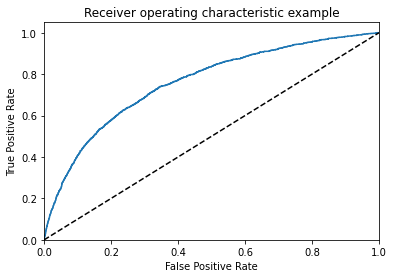

In [89]:
fig, ax = plt.subplots()
ax.plot(fpr_N, tpr_N, label='ROC curve (area = %0.2f)' % roc_auc_N)
ax.plot([0, 1], [0, 1], 'k--')  # diagonal line
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
plt.show()

## 9.1. Avec SMOTE

In [90]:
with timer("Fine tuning with SMOTE and LGBM"):
    t_clf = time.perf_counter()
    pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                           ("sampler", oversampler_2),
                                           ("classifier", clf13)])
    # verbose=-1 ne fonctionne pas donc je supprime tous les warnings.
    warnings.filterwarnings("ignore")
    gs_S = GridSearchCV(
        pipeline,
        parm,
        cv=5,
        n_jobs=None,
        scoring="roc_auc",
        # scoring=["roc_auc", "accuracy"],
        # refit="roc_auc",
        # n_iter=5, # seulement pour RandomSearchCV ?
        # random_state=42, # seulement pour RandomSearchCV ?
    ).fit(X_train, y_train)

    n_loops = math.prod([len(i) for i in parm.values()])
    t_mean = (time.perf_counter() - t_clf)/(n_loops)
    if t_mean > 10:
        t_mean = round(t_mean, 0)
    elif t_mean > 1:
        t_mean = round(t_mean, 2)
    elif t_mean > .001:
        t_mean = round(t_mean, 3)
    else:
        pass

    print("Score:", round(gs_S.best_score_, 3))
    print("Obtained with:", gs_S.best_params_["classifier"])
    print("run_time per search (s)", t_mean)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.03162277660168379, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03162277660168379
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[Light

In [91]:
#y_pred = rs_cv.best_estimator_[best_algorithm].predict(X_test)

In [92]:
y_pred_S = gs_S.best_estimator_.predict(X_test)
# On peut aussi faire un predict_proba avec un seuil < .5 au lieu de faire un
# oversampling ou de jouer sur class_weights.
y_pred_proba_S = gs_S.best_estimator_.predict_proba(X_test)
y_pred_proba_positive_S = y_pred_proba_S[:, 1]

In [93]:
fpr_S, tpr_S, thresholds_S = roc_curve(y_test, y_pred_proba_positive_S)
roc_auc_S = auc(fpr_S, tpr_S)
roc_auc_S

0.7424031012767514

0.76

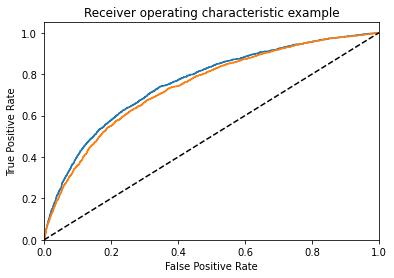

In [94]:
fig, ax = plt.subplots()
ax.plot(fpr_N, tpr_N, label='ROC curve (area = %0.2f)' % roc_auc_N)
ax.plot(fpr_S, tpr_S, label='ROC curve (area = %0.2f)' % roc_auc_S)
ax.plot([0, 1], [0, 1], 'k--')  # diagonal line
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
plt.show()

# 10. Fine tuning using an Fbeta scoring

In [95]:
df.TARGET.value_counts(
    sort=True,
    ascending=False,
    dropna=True,
)

0.0    91904
1.0     8093
Name: TARGET, dtype: int64

In [96]:
y_test.value_counts(
    sort=True,
    ascending=False,
    dropna=True,
)

0.0    18386
1.0     1614
Name: TARGET, dtype: int64

In [97]:
cm = confusion_matrix(y_test, y_pred_S)

In [98]:
def plot_confusion_matrix(cf_matrix):

    plt.figure(figsize=(7, 7))

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in

                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in

                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in

              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')



    plt.title("Prédiction des données")

    plt.show()

In [99]:
cm_df = pd.DataFrame(cm,
                     index=['Positive', 'Negative'],
                     columns=['Positive', 'Negative'])
display(cm_df)

,Positive,Negative
Positive,18362,24
Negative,1597,17


    Confusion                 Predicted
    Matrix               Positive    Negative
              Positive      TP          FN     →  Recall (= Sensitivity, TPR)
    Actual    Negative      FP          TN     →  FP Rate (= 1-Specificity)
                            ↓           ↓
                        Precision  False Omission Rate

                           1812          8
                            171      	9

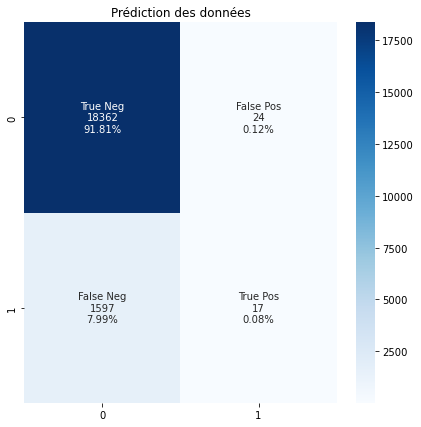

In [100]:
plot_confusion_matrix(cm)

- Les "négatifs" sont les zéros et correspondent aux prêts remboursés.
- Les "positifs" sont les uns et correspondent aux prêts non-remboursés.

Donc là le modèle a accordé 171 prêts qui ne seront pas remboursés et a refusé
8 prêts qui auraient été remboursés.  
C'est très problématique.  
- Un FN (prêt accordé non-remboursé) nous fait perdre la part non-remboursée du
prêt. 100% dans le pire des cas.
- Un FP (prêt remboursable non-accordé) nous fait perdre seulement le taux
d'intérêts qu'on aurait touchés sur ce prêt, disons 10%.

Considérons donc qu'un FN nous est 10fois plus coûteux qu'un FP et qu'on veut
donc minimiser le nombre (10FN+FP).

Je veux donc un $\beta$ qui beaucoup plus d'importance au fait d'avoir un Recall
proche de 1 qu'au fait d'avoir une Precision proche de 1.  
Dans ce cas il faut choisir $\beta = 2$.

In [101]:
parm = {}
parm["classifier__boosting_type"] = [
    "gbdt",
]
parm["classifier__learning_rate"] = [
    10**-1.1,
    10**-1,
    10**-.9
]
parm["classifier__num_leaves"] = [
    25,
    30,
    35,
]
#parm["classifier__num_iterations"] = [
#    10**3,
#    10**4,
#]
parm["classifier__feature_fraction"] = [
    .9,
]
parm["classifier__lambda_l1"] = [
    10**-2.5,
    10**-2,
    10**-1.5,
]
parm["classifier__lambda_l2"] = [
    10**-2,
    10**-1.5,
    10**-1,
]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [
    7,
    8,
    9,
]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [
    .9,
]
#parm["classifier__silent"] = [-1]
#parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]

In [102]:
math.prod([len(i) for i in parm.values()])

243

In [103]:
%%script echo
with timer("Fine tuning with SMOTE and LGBM"):
    t_clf = time.perf_counter()
    pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                           ("sampler", oversampler_2),
                                           ("classifier", clf13)])
    # verbose=-1 ne fonctionne pas donc je supprime tous les warnings.
    warnings.filterwarnings("ignore")
    fbeta_scorer = make_scorer(fbeta_score, beta=.5)
    gs_Sb = GridSearchCV(
        pipeline,
        parm,
        cv=5,
        n_jobs=None,
        scoring=fbeta_scorer,
        # scoring=["roc_auc", "accuracy"],
        # refit="roc_auc",
        # n_iter=5, # seulement pour RandomSearchCV ?
        # random_state=42, # seulement pour RandomSearchCV ?
    ).fit(X_train, y_train)

    n_loops = math.prod([len(i) for i in parm.values()])
    t_mean = (time.perf_counter() - t_clf)/(n_loops)
    if t_mean > 10:
        t_mean = round(t_mean, 0)
    elif t_mean > 1:
        t_mean = round(t_mean, 2)
    elif t_mean > .001:
        t_mean = round(t_mean, 3)
    else:
        pass

    print("Score:", round(gs_Sb.best_score_, 3))
    print("Obtained with:", gs_Sb.best_params_["classifier"])
    print("run_time per search (s)", t_mean)

Couldn't find program: 'echo'


In [104]:
%%script echo
y_pred_Sb = gs_Sb.best_estimator_.predict(X_test)

Couldn't find program: 'echo'


In [105]:
%%script echo
cm = confusion_matrix(y_test, y_pred_Sb)

Couldn't find program: 'echo'


In [106]:
%%script echo
cm_df = pd.DataFrame(cm,
                     index=['Positive', 'Negative'],
                     columns=['Positive', 'Negative'])
display(cm_df)

Couldn't find program: 'echo'


              Positive 	Negative
    Positive 	1808 	12
    Negative 	172 	8

In [107]:
#beta = .1
#fb_score = fbeta_score(y_test, y_pred_S, beta=beta)
#fb_score

In [108]:
#beta = .01
#fb_score = fbeta_score(y_test, y_pred_S, beta=beta)
#fb_score

In [109]:
%%script echo
with timer("Fine tuning with SMOTE and LGBM"):
    t_clf = time.perf_counter()
    pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                           ("sampler", oversampler_2),
                                           ("classifier", clf13)])
    # verbose=-1 ne fonctionne pas donc je supprime tous les warnings.
    warnings.filterwarnings("ignore")
    fbeta_scorer = make_scorer(fbeta_score, beta=2)
    gs_Sb = GridSearchCV(
        pipeline,
        parm,
        cv=5,
        n_jobs=None,
        scoring=fbeta_scorer,
        # scoring=["roc_auc", "accuracy"],
        # refit="roc_auc",
        # n_iter=5, # seulement pour RandomSearchCV ?
        # random_state=42, # seulement pour RandomSearchCV ?
    ).fit(X_train, y_train)

    n_loops = math.prod([len(i) for i in parm.values()])
    t_mean = (time.perf_counter() - t_clf)/(n_loops)
    if t_mean > 10:
        t_mean = round(t_mean, 0)
    elif t_mean > 1:
        t_mean = round(t_mean, 2)
    elif t_mean > .001:
        t_mean = round(t_mean, 3)
    else:
        pass

    print("Score:", round(gs_Sb.best_score_, 3))
    print("Obtained with:", gs_Sb.best_params_["classifier"])
    print("run_time per search (s)", t_mean)

Couldn't find program: 'echo'


In [110]:
%%script echo
y_pred_Sb = gs_Sb.best_estimator_.predict(X_test)

Couldn't find program: 'echo'


In [111]:
%%script echo
cm = confusion_matrix(y_test, y_pred_Sb)

Couldn't find program: 'echo'


In [112]:
%%script echo
cm_df = pd.DataFrame(cm,
                     index=['Positive', 'Negative'],
                     columns=['Positive', 'Negative'])
display(cm_df)

Couldn't find program: 'echo'


Avec 10_000

 	           Positive 	Negative
    Positive 	1809 	11
    Negative 	172 	8

Avec 100_000

 	           Positive 	Negative
    Positive 	18328 	58
    Negative 	1567 	47

Ça s'améliore mais c'est tout de même extrêmement mauvais.
Je vais essayer de créer ma fonction de scoring à la main.

In [113]:
import sklearn.metrics

In [114]:
yt = [0, 1, 1, 0, 0]
yp = [1, 0, 1, 0, 0]
a = yt == yp
a

False

In [115]:
sklearn.metrics._classification._weighted_sum(a, None, True)

0.0

In [116]:
yt = np.array(yt)
yp = np.array(yp)
a = yt == yp
a

array([False, False,  True,  True,  True])

In [117]:
sklearn.metrics._classification._weighted_sum(a, None, True)

0.6

In [118]:
%%script echo
def my_scoring(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    # multioutput="uniform_average",
    normalize=True,
):

    y_type, y_true, y_pred = sklearn.metrics._classification._check_targets(
        y_true, y_pred
    )
    sklearn.metrics._classification.check_consistent_length(
        y_true, y_pred, sample_weight
    )
    FN = y_true - y_pred == 1
    FN = sklearn.metrics._classification._weighted_sum(
        FN, sample_weight, normalize
    )
    FP = y_true - y_pred == -1
    FP = sklearn.metrics._classification._weighted_sum(
        FP, sample_weight, normalize
    )
    # score = y_true == y_pred
    # score = sklearn.metrics._classification._weighted_sum(
    #     score, sample_weight, normalize
    # )
    score = 1 - (10*FN+FP)/11

    return score

Couldn't find program: 'echo'


In [119]:
%%script echo
with timer("Fine tuning with SMOTE and LGBM"):
    t_clf = time.perf_counter()
    pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                           ("sampler", oversampler_2),
                                           ("classifier", clf13)])
    # verbose=-1 ne fonctionne pas donc je supprime tous les warnings.
    warnings.filterwarnings("ignore")
    gs_Sb = GridSearchCV(
        pipeline,
        parm,
        cv=5,
        n_jobs=None,
        scoring=my_scoring,
        # scoring=["roc_auc", "accuracy"],
        # refit="roc_auc",
        # n_iter=5, # seulement pour RandomSearchCV ?
        # random_state=42, # seulement pour RandomSearchCV ?
    ).fit(X_train, y_train)

    n_loops = math.prod([len(i) for i in parm.values()])
    t_mean = (time.perf_counter() - t_clf)/(n_loops)
    if t_mean > 10:
        t_mean = round(t_mean, 0)
    elif t_mean > 1:
        t_mean = round(t_mean, 2)
    elif t_mean > .001:
        t_mean = round(t_mean, 3)
    else:
        pass

    print("Score:", round(gs_Sb.best_score_, 3))
    print("Obtained with:", gs_Sb.best_params_["classifier"])
    print("run_time per search (s)", t_mean)

Couldn't find program: 'echo'


Obtained with: LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.9,
               lambda_l1=0.0031622776601683794, lambda_l2=0.01,
               learning_rate=0.07943282347242814, max_depth=7,
               min_gain_to_split=0.02, min_sum_hessian_in_leaf=1, num_leaves=25,
               random_state=42, verbose=-1)
run_time per search (s) 55.0
Fine tuning with SMOTE and LGBM - done in 13393s

In [120]:
%%script echo
y_pred_Sb = gs_Sb.best_estimator_.predict(X_test)

Couldn't find program: 'echo'


In [121]:
%%script echo
cm = confusion_matrix(y_test, y_pred_Sb)

Couldn't find program: 'echo'


In [122]:
%%script echo
cm_df = pd.DataFrame(cm,
                     index=['Positive', 'Negative'],
                     columns=['Positive', 'Negative'])
display(cm_df)

Couldn't find program: 'echo'


 	           Positive 	Negative
    Positive 	18372 	14
    Negative 	1598 	16

In [123]:
%%script echo
y_pred_proba_Sb = gs_Sb.best_estimator_.predict_proba(X_test)
y_pred_proba_positive_Sb = y_pred_proba_Sb[:, 1]

Couldn't find program: 'echo'


In [124]:
%%script echo
fpr_Sb, tpr_Sb, thresholds_Sb = roc_curve(y_test, y_pred_proba_positive_Sb)
roc_auc_Sb = auc(fpr_Sb, tpr_Sb)
roc_auc_Sb

Couldn't find program: 'echo'


.74

In [125]:
%%script echo
def my_scoring(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    # multioutput="uniform_average",
    normalize=True,
):

    y_type, y_true, y_pred = sklearn.metrics._classification._check_targets(
        y_true, y_pred
    )
    sklearn.metrics._classification.check_consistent_length(
        y_true, y_pred, sample_weight
    )
    FN = y_true - y_pred == 1
    FN = sklearn.metrics._classification._weighted_sum(
        FN, sample_weight, normalize
    )
    FP = y_true - y_pred == -1
    FP = sklearn.metrics._classification._weighted_sum(
        FP, sample_weight, normalize
    )
    # score = y_true == y_pred
    # score = sklearn.metrics._classification._weighted_sum(
    #     score, sample_weight, normalize
    # )
    score = 1 - (FN+10*FP)/11

    return score

In [126]:
%%script echo
with timer("Fine tuning with SMOTE and LGBM"):
    t_clf = time.perf_counter()
    pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                           ("sampler", oversampler_2),
                                           ("classifier", clf13)])
    # verbose=-1 ne fonctionne pas donc je supprime tous les warnings.
    warnings.filterwarnings("ignore")
    gs_Sb = GridSearchCV(
        pipeline,
        parm,
        cv=5,
        n_jobs=None,
        scoring=my_scoring,
        # scoring=["roc_auc", "accuracy"],
        # refit="roc_auc",
        # n_iter=5, # seulement pour RandomSearchCV ?
        # random_state=42, # seulement pour RandomSearchCV ?
    ).fit(X_train, y_train)

    n_loops = math.prod([len(i) for i in parm.values()])
    t_mean = (time.perf_counter() - t_clf)/(n_loops)
    if t_mean > 10:
        t_mean = round(t_mean, 0)
    elif t_mean > 1:
        t_mean = round(t_mean, 2)
    elif t_mean > .001:
        t_mean = round(t_mean, 3)
    else:
        pass

    print("Score:", round(gs_Sb.best_score_, 3))
    print("Obtained with:", gs_Sb.best_params_["classifier"])
    print("run_time per search (s)", t_mean)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.0031622776601683794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031622776601683794
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Score: nan
Obtained with: LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.9,
               lambda_l1=0.0031622776601683794, lambda_l2=0.01,
               learning_rate=0.07943282347242814, max_depth=7,
               min_gain_to_split=0.02, m

Obtained with: LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.9,
               lambda_l1=0.0031622776601683794, lambda_l2=0.01,
               learning_rate=0.07943282347242814, max_depth=7,
               min_gain_to_split=0.02, min_sum_hessian_in_leaf=1, num_leaves=25,
               random_state=42, verbose=-1)
run_time per search (s) 56.0
Fine tuning with SMOTE and LGBM - done in 13620s

In [127]:
%%script echo
y_pred_Sb = gs_Sb.best_estimator_.predict(X_test)

In [128]:
%%script echo
cm = confusion_matrix(y_test, y_pred_Sb)

In [129]:
%%script echo
cm_df = pd.DataFrame(cm,
                     index=['Positive', 'Negative'],
                     columns=['Positive', 'Negative'])
display(cm_df)

,Positive,Negative
Positive,18364,22
Negative,1598,16


 	            	Positive 	Negative
    Positive 	18364 	22
    Negative 	1598 	16

In [130]:
%%script echo
y_pred_proba_Sb = gs_Sb.best_estimator_.predict_proba(X_test)
y_pred_proba_positive_Sb = y_pred_proba_Sb[:, 1]

In [131]:
%%script echo
fpr_Sb, tpr_Sb, thresholds_Sb = roc_curve(y_test, y_pred_proba_positive_Sb)
roc_auc_Sb = auc(fpr_Sb, tpr_Sb)
roc_auc_Sb

0.7386866738080304

.739

In [145]:
import pickle

In [146]:
with open('model.pkl', 'wb') as f:
    pickle.dump(gs_Sb.best_estimator_, f)

In [132]:
=r

SyntaxError: invalid syntax (870885351.py, line 1)

In [134]:
clf = LGBMClassifier(
    nthread=-1,
    #device_type='gpu',
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=11,
    num_leaves=58,
    colsample_bytree=0.613,
    subsample=0.708,
    max_bin=407,
    reg_alpha=3.564,
    reg_lambda=4.930,
    min_child_weight=6,
    min_child_samples=165,
    #keep_training_booster=True,
    silent=-1,
    verbose=-1,
)

clf.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='auc',
    # verbose=500,
    verbose=-1,
    early_stopping_rounds=500
)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[1]	training's auc: 0.712757	training's binary_logloss: 0.280684	valid_1's auc: 0.685659	valid_1's binary_logloss: 0.280049
[2]	training's auc: 0.742221	training's binary_logloss: 0.280074	valid_1's auc: 0.714427	valid_1's binary_logloss: 0.279515
[3]	training's auc: 0.745765	training's binary_logloss: 0.279506	valid_1's auc: 0.720094	valid_1's binary_logloss: 0.279011
[4]	training's auc: 0.745397	training's binary_logloss: 0.279078	valid_1's auc: 0.719608	valid_1's binary_logloss: 0.278637
[5]	training's auc: 0.747396	training's binary_logloss: 0.278503	valid_1's auc: 0.721718	valid_1's binary_logloss: 0.278129
[6]	training's auc: 0.747921	training's binary_logloss: 0.278061	valid_1's auc: 0.721898	valid_1's binary_logloss: 0.27775
[7]	training's auc: 0.757719	training's binary_logloss: 0.277742	valid_1's auc: 0.728349	valid_1's binary_logloss: 0.277478
[8]	training's auc:

LGBMClassifier(colsample_bytree=0.613, learning_rate=0.01, max_bin=407,
               max_depth=11, min_child_samples=165, min_child_weight=6,
               n_estimators=5000, nthread=-1, num_leaves=58, reg_alpha=3.564,
               reg_lambda=4.93, silent=-1, subsample=0.708, verbose=-1)

LGBMClassifier(colsample_bytree=0.613, learning_rate=0.01, max_bin=407,
               max_depth=11, min_child_samples=165, min_child_weight=6,
               n_estimators=5000, nthread=-1, num_leaves=58, reg_alpha=3.564,
               reg_lambda=4.93, silent=-1, subsample=0.708, verbose=-1)

In [138]:
y_pred_clf = clf.predict(X_test)

In [139]:
cm = confusion_matrix(y_test, y_pred_clf)

In [140]:
cm_df = pd.DataFrame(cm,
                     index=['Positive', 'Negative'],
                     columns=['Positive', 'Negative'])
display(cm_df)

,Positive,Negative
Positive,18348,38
Negative,1583,31


            	Positive 	Negative
    Positive 	18348 	38
    Negative 	1583 	31

Bon bah même avec leurs paramètres le résultat est mauvais.

In [143]:
y_pred_proba_clf = clf.predict_proba(X_test)
y_pred_proba_positive_clf = y_pred_proba_clf[:, 1]

In [144]:
fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_pred_proba_positive_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)
roc_auc_clf

0.7645288270222306

.765

# 10. Applying the fine-tuned best classifier for the final results

# 11. Features' importance

## 11.1. SHAP

In [ ]:
%%script echo
# InvalidModelError: Model type not yet supported by TreeExplainer:
# <class 'imblearn.pipeline.Pipeline'>
explainer = shap.TreeExplainer(gs_S.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
# Pas nécessaire de le rappeler normalement
feature_names = imputer.get_feature_names_out()

In [ ]:
# MemoryError: Unable to allocate 148. GiB for an array with shape
# (3312, 5984000) and data type float64
K = 10
X_train_sample = shap.sample(X_train, K)
print(X_train_sample.shape)
explainer = shap.KernelExplainer(
    gs_Sb.best_estimator_.predict_proba,
    X_train_sample
)

In [ ]:
# Je rajoute ".values" uniquement pour supprimer le million de warnings "X does
# not have valid feature names, but MinMaxScaler was fitted with feature names"
# que SHAP sort.
# Ça ne fonctionne pas donc je supprime tous les warnings.
warnings.filterwarnings("ignore")
shap_values = explainer.shap_values(X_test, feature_names=feature_names)

In [ ]:
shap.summary_plot(shap_values, X_test.values, feature_names=feature_names)

In [ ]:
scaler.get_feature_names_out(input_features=feature_names)[:9]

In [ ]:
len(feature_names)

In [ ]:
X_test.shape, X_train_sample.shape

In [ ]:
X_test.columns[:3]

In [ ]:
X_train_sample.columns[:3]

## 11.2. LIME

# Annexes

In [ ]:
print("Precision:",
      precision_score(gs_S.predict(X_test), y_test))
      # precision_score(rs.best_estimator_.predict(X_test), y_test))
print("Recall:",
      recall_score(gs_S.best_estimator_.predict(X_test), y_test))
print("ROC AUC Score:",
      roc_auc_score(gs_S.best_estimator_.predict(X_test), y_test))

In [ ]:
plot la courbe roc du meilleur pour chaque sampler

In [ ]:
shap (et lime)

In [ ]:
%%script echo
#rs_cv.fit(X_train, y_train)
#rs_cv.fit(X_train_u, y_train_u)
rs_cv.fit(X_train_o, y_train_o)

for algorithm in classifiers.keys():
    print(f"Best parameters for {algorithm}: {rs_cv.best_params_[algorithm]}")
    print(f"Best AUC score for {algorithm}: {rs_cv.best_score_[algorithm]['roc_auc']:.3f}")
    print(f"Best accuracy score for {algorithm}: {rs_cv.best_score_[algorithm]['accuracy']:.3f}")

#best_algorithm = rs_cv.best_estimator_.keys()[0]
best_algorithm = rs_cv.best_estimator_.named_steps.keys()
print(f"Overall best algorithm: {best_algorithm}")
print(f"Best AUC score: {rs_cv.best_score_[best_algorithm]['roc_auc']:.3f}")
print(f"Best accuracy score: {rs_cv.best_score_[best_algorithm]['accuracy']:.3f}")

In [ ]:
gs_S.predict(X_test).shape

In [ ]:
y_test.shape